# Lab 02: Credit Ratings

---
author: Ye Yuan
date: September 25, 2024
embed-resources: true
---

## Introduction

The purpose of this report is to develop a regression model that predicts the credit ratings of individuals based on their income and demographic information. By leveraging existing customer data, including income levels, age, education, gender, student status, marital status, and ethnicity, the goal is to create a cost-effective alternative to relying on external credit agencies for credit assessments. This approach aims to reduce expenses associated with purchasing credit ratings while maintaining accurate and reliable predictions.

## Methods

Data
The dataset utilized for this analysis comprises two primary subsets: credit_train and credit_test. Each subset includes the following features:

Rating: Numerical credit rating of the individual.

Income: Annual income in appropriate currency units.

Age: Age of the individual in years.

Education: Years of education completed.

Gender: Gender of the individual (Male/Female).

Student: Indicates if the individual is a student (Yes/No).

Married: Marital status of the individual (Yes/No).

Ethnicity: Ethnic background of the individual.

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from joblib import dump

### Data

In [2]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")

In [3]:
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In [4]:
# summary statistics
# Mean and Std of Rating
rating_mean = credit_train['Rating'].mean()
rating_std = credit_train['Rating'].std()
# Group by Student status and calculate mean, std, and count for Rating
student_group = credit_train.groupby('Student')['Rating'].agg(['mean', 'std', 'count'])
# Group by Marriage status and calculate mean, std, and count for Rating
married_group = credit_train.groupby('Married')['Rating'].agg(['mean', 'std', 'count'])
# Correlation of Rating with Age and Income
age_correlation = credit_train['Rating'].corr(credit_train['Age'])
income_correlation = credit_train['Rating'].corr(credit_train['Income'])
# Proportion of missing data for each column
missing_proportion = credit_train.isna().mean()
# Print the results
print("Rating Mean:", rating_mean)
print("Rating Std:", rating_std)

print("\nRating Statistics by Student Status:\n", student_group)
print("\nRating Statistics by Married Status:\n", married_group)

print("\nCorrelation with Rating:")
print("Age Correlation:", age_correlation)
print("Income Correlation:", income_correlation)

print("\nMissing Data Proportion:\n", missing_proportion)


Rating Mean: 347.609375
Rating Std: 148.8931046679028

Rating Statistics by Student Status:
                mean         std  count
Student                               
No       349.511737  148.003525    213
Yes      338.473684  149.164476     19

Rating Statistics by Married Status:
                mean         std  count
Married                               
No       329.397959  132.039649     98
Yes      358.905063  157.797935    158

Correlation with Rating:
Age Correlation: 0.1430318874061348
Income Correlation: 0.7708422040157118

Missing Data Proportion:
 Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64


Rating Distribution: The average credit rating across the dataset is approximately 348, with a high level of variability as indicated by a standard deviation of about 149. This suggests a wide range of creditworthiness among individuals.

Student Status: Non-students have a slightly higher average credit rating (around 350) compared to students (around 338). However, the variability within both groups is quite similar.

Marital Status: Married individuals have a higher average credit rating (about 359) compared to unmarried individuals (around 329). The variation is also larger for married individuals, indicating more diverse credit ratings within this group.

Correlation with Rating:

Age shows a weak positive correlation with credit rating (0.143), suggesting age has little influence on the score.
Income has a strong positive correlation (0.771) with credit rating, indicating that as income increases, credit rating tends to increase as well.

Missing Data Proportion:

The dataset contains some missing values, particularly for Age (12.89%), Education (9.77%), Student status (9.38%), and Ethnicity (9.77%). However, columns like Rating, Income, Gender, and Married have minimal or no missing values.

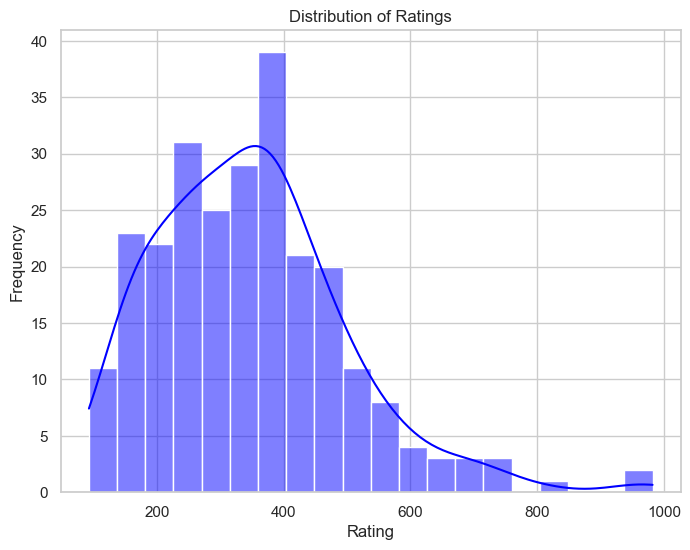

C:\Users\yy815\AppData\Local\Temp\ipykernel_22756\2125848606.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Student', y='Rating', data=student_mean, palette='pastel')


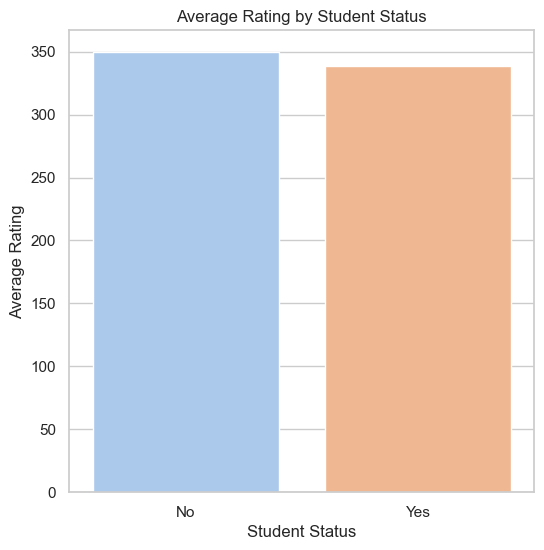

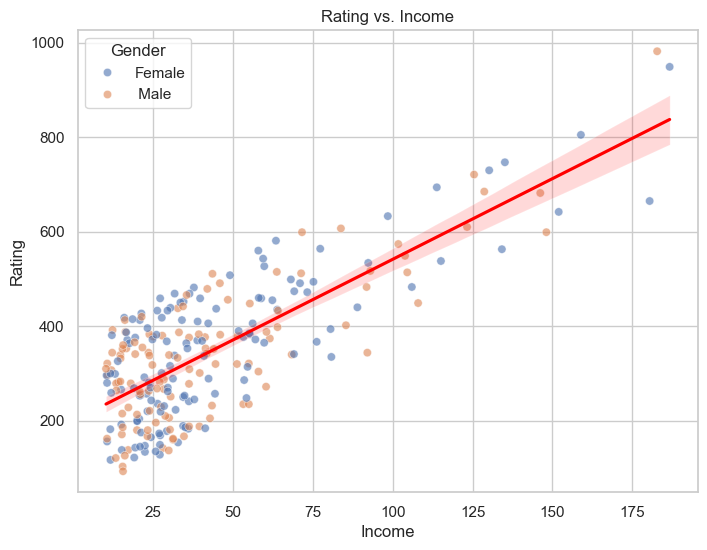

C:\Users\yy815\AppData\Local\Temp\ipykernel_22756\2125848606.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='viridis')


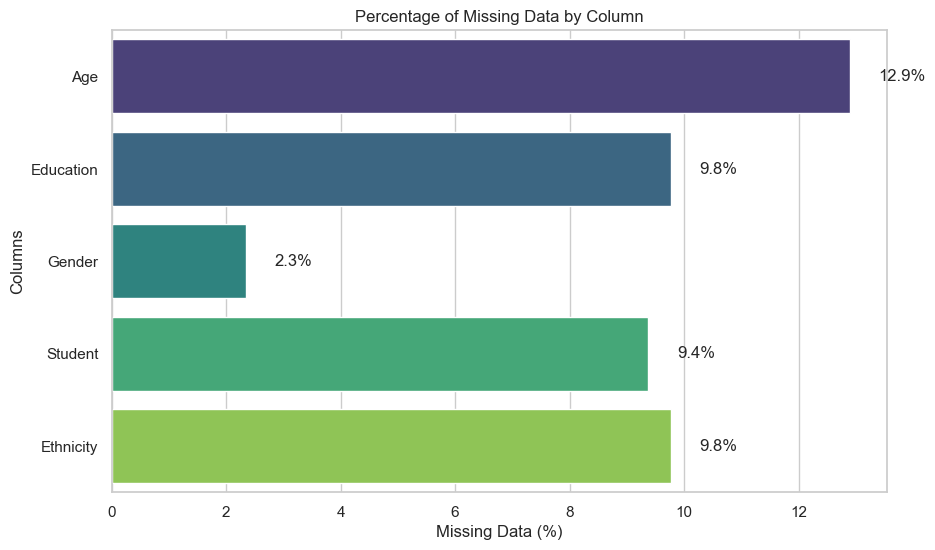

In [5]:
# visualizations
sns.set(style="whitegrid")

# 1. Histogram of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(credit_train['Rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# 2. Bar Plot of Average Ratings by Student Status
student_mean = credit_train.groupby('Student')['Rating'].mean().reset_index()
plt.figure(figsize=(6, 6))
sns.barplot(x='Student', y='Rating', data=student_mean, palette='pastel')
plt.title('Average Rating by Student Status')
plt.xlabel('Student Status')
plt.ylabel('Average Rating')
plt.show()

# 3. Scatter Plot of Rating vs. Income
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='Rating', data=credit_train, hue='Gender', alpha=0.6)
sns.regplot(x='Income', y='Rating', data=credit_train, scatter=False, color='red')
plt.title('Rating vs. Income')
plt.xlabel('Income')
plt.ylabel('Rating')
plt.show()

# 4. Bar Plot of Missing Data Proportions
missing_percent = credit_train.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0]
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='viridis')
plt.title('Percentage of Missing Data by Column')
plt.xlabel('Missing Data (%)')
plt.ylabel('Columns')
for index, value in enumerate(missing_percent.values):
    plt.text(value + 0.5, index, f'{value:.1f}%', va='center')
plt.show()

Visualizations:

Distribution of Ratings: A histogram demonstrates a skewed distribution of credit ratings with a peak around 400, tapering off as the score increases.

Average Rating by Student Status: A bar plot compares the average credit ratings between students and non-students, showing only minor differences.

Rating vs. Income: A scatter plot reveals a positive relationship between income and credit rating, with some variation by gender.

Missing Data by Column: A bar chart illustrates the extent of missing data across different columns, with age being the most affected.

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((256, 7), (256,), (64, 7), (64,))

In [8]:
numeric_features = ['Income','Age','Education']
categorical_features = ['Gender','Student','Married','Ethnicity']
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [9]:
# define parameter grid
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "regressor__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "regressor__metric": ["euclidean", "manhattan"],
}

In [10]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_root_mean_squared_error")

In [11]:
# train models
grid_search.fit(X_train, y_train)

c:\Users\yy815\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Income',
                                                                          'Age',
                                                                          'Education']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Gender',
                                                                          'Student',
                                                                          'Married',
                                                                          'Ethnicity'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'preprocessor__cat__onehot__drop': [None, 'first'],
                         'preprocessor__num__scaler': [None, StandardScaler()],
                         'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17,
                                                    19, 21]},
             scoring='neg_root_mean_squared_error')

In [12]:
# print best parameters found and best (cross-validated) score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # Multiply by -1 to get positive RMSE

Best Parameters: {'preprocessor__cat__onehot__drop': 'first', 'preprocessor__num__scaler': None, 'regressor__metric': 'manhattan', 'regressor__n_neighbors': 19}
Best RMSE: 101.15720197641228


In [13]:
# Access all results
results = grid_search.cv_results_

# Create a DataFrame for better visualization
import pandas as pd

results_df = pd.DataFrame(results)

# Add a column for positive RMSE
results_df['mean_test_rmse'] = -results_df['mean_test_score']

# Display sorted results by RMSE
sorted_results = results_df.sort_values('mean_test_rmse')
print(sorted_results[['param_regressor__n_neighbors', 'param_regressor__metric', 'mean_test_rmse']])


    param_regressor__n_neighbors param_regressor__metric  mean_test_rmse
58                            19               manhattan      101.157202
57                            17               manhattan      101.159111
7                             17               euclidean      101.291505
48                            19               euclidean      101.303405
56                            15               manhattan      101.333178
..                           ...                     ...             ...
38                            19               manhattan      121.977904
39                            21               manhattan      123.070630
32                             7               manhattan      123.521691
31                             5               manhattan      125.579386
30                             3               manhattan      128.161910

[80 rows x 3 columns]


The modeling process employed a k-nearest neighbors (KNN) regression approach to predict credit ratings based on the input features. A pipeline was created to preprocess both numeric and categorical features, handling missing values and standardizing the data.

Model Training
Preprocessing:

Numeric Features: Imputed missing values using the mean and standardized the features.
Categorical Features: Imputed missing values using the most frequent category and one-hot encoded them.
Model Selection:

Hyperparameter Tuning: A grid search was conducted over a range of K values (neighbors in the KNN model) and distance metrics (Euclidean and Manhattan).
The best model was identified based on the lowest Root Mean Squared Error (RMSE) during cross-validation.
Best Model Parameters:

The optimal model had 19 neighbors and used the Manhattan distance metric.
Training RMSE: The cross-validated RMSE on the training set was approximately 101.16.

Model Testing
The best-performing model was tested on a separate test set, and the RMSE on this unseen data was calculated to gauge the model's predictive performance.

## Results

In [14]:
# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.2f}")

Test RMSE: 101.77


In [15]:
dump(best_model, "credit-ratings.joblib")
print("Model serialized and saved as 'model.joblib'.")

Model serialized and saved as 'model.joblib'.


Results

Test RMSE: The final model achieved a test RMSE of approximately 101.77, indicating the average error between the predicted and actual credit ratings. 

The model performed reasonably well, with consistent performance across training and test data sets.

## Discussion

The KNN model trained to predict credit ratings shows promise as a predictive tool, with an RMSE around 100 on both training and test data. Given its performance, the model could be considered for deployment in predicting credit scores in scenarios similar to the training environment.

Limitations & Potential Improvements
Model Performance: While the model performs adequately, the relatively high RMSE suggests room for improvement, potentially by exploring other regression algorithms like Random Forest or Gradient Boosting.

Feature Selection: Further feature engineering could enhance the model's performance, such as deriving interaction terms or normalizing numeric features more carefully.

Ethical and Legal Considerations: Using demographic information (e.g., gender, ethnicity) raises ethical concerns and potential legal constraints, especially in financial decision-making. Before deploying the model, careful consideration of biases and compliance with anti-discrimination laws is essential.

Suitability of Features
The features used—income, age, education, student status, marital status, and ethnicity—are logical predictors for credit ratings as they are common factors considered in creditworthiness assessments. However, the ethical implications of using certain demographic features should be critically evaluated to avoid bias.

### Conclusion

Conclusion
The trained model provides a starting point for predicting credit ratings based on existing customer data. While the results are promising, further optimization and ethical considerations must be addressed before deploying such a model in a real-world banking context.